### Credit scoring and movie reviews classification

#### Arina Sitnikova

Here we'll predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's implement a function that will replace the NaN values by the median in each column of the table.

In [2]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Reading the data:

In [3]:
data = pd.read_csv('credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the distribution of the target variable:

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

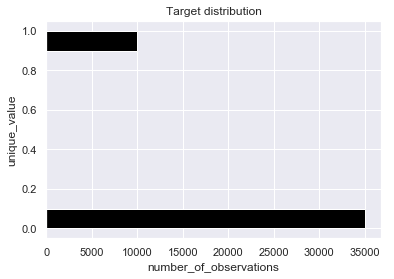

In [9]:
sns.set()
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='black')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts(normalize=True) 

Selecting all the features and dropping the target:

In [10]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Then we apply a function that replaces all NaN values with the median value of the corresponding feature.

In [11]:
table = impute_nan_with_median(data)

Split the target and features - now we get a training set.

In [12]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

First we'll build a Decision Tree Classifier with the help of GridSearchCV, which maximize the area under the ROC curve:

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [15]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

We will look through such values of hyperparameters:

In [16]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [21]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [63]:
tree_grid = GridSearchCV(dt, tree_params, cv = skf, scoring='roc_auc')

In [64]:
tree_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [65]:
tree_grid.best_score_, tree_grid.best_params_

(0.8203023476209635, {'max_depth': 7, 'max_features': 6})

In [67]:
tree_grid.cv_results_['std_test_score'][10]

0.002758483553592935

Thus, we got the best score of 0.82. In addition, the standard deviation of the metric on the cross-validation is just 0.002, which means that the cross-validation is stable under optimal combinations of hyperparameters.

Now we'll try Random Forest Classifier, which is basically an ensemble of decision trees and typically performs much better than a single tree. First, let's build the classifier from scratch:

In [18]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=10, max_features=10, 
                 random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        pass

        for i in range(self.n_estimators):
            
            np.random.seed(self.random_state + i)
            feat_to_use_ids = np.random.choice(range(X.shape[1]), self.max_features, 
                                               replace=False)
            examples_to_use = list(set(np.random.choice(range(X.shape[0]), X.shape[0],
                                                        replace=True)))
            
            self.feat_ids_by_tree.append(feat_to_use_ids)
            
            dt = DecisionTreeClassifier(max_depth=self.max_depth, 
                                        max_features=self.max_features, 
                                        random_state = self.random_state)

            dt.fit(X[examples_to_use, :][:, feat_to_use_ids], y[examples_to_use])
            self.trees.append(dt)
        return self
    
    def predict_proba(self, X):
        pass

        predictions = []  
        for i in range(self.n_estimators):
            feat_to_use_ids = self.feat_ids_by_tree[i]
            predictions.append(self.trees[i].predict_proba(X[:,feat_to_use_ids]))
        return np.mean(predictions, axis=0)

In [21]:
cv_auc = cross_val_score(RandomForestClassifierCustom(max_depth=7, max_features=6), 
                          X.values, y.values, scoring="roc_auc", cv=skf)
print(round(np.mean(cv_auc), 3))

0.832


This time, we got a higher score. However, when we try the sklearn implementation of the RF, it differs a little bit:

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

In [19]:
rcf = RandomForestClassifier(class_weight='balanced', n_estimators=10, 
                             random_state=17)

In [22]:
tree_grid2 = GridSearchCV(rcf, tree_params, cv = skf, scoring='roc_auc')

In [23]:
fit2 = tree_grid2.fit(X, y)

In [227]:
fit2.cv_results_['mean_test_score'][10]

0.8291437173578207

Overall, the accuracy is similar to the DT model's. However, here we used DT's hyperparameters that might not be suitable for an ensemble. Let's try other hyperparameters:

In [24]:
max_depth_values = range(5, 15)
max_features_values = [4, 5, 6, 7]
forest_params = {
    'max_depth': max_depth_values,
    'max_features': max_features_values
}

In [25]:
rfc2 = RandomForestClassifier(class_weight='balanced', n_estimators=10, random_state=17)

In [26]:
tree_grid3 = GridSearchCV(rfc2, forest_params, cv = skf, scoring='roc_auc')

In [27]:
fit3 = tree_grid3.fit(X, y)

In [97]:
fit3.best_params_

{'max_depth': 8, 'max_features': 4}

Now let's compare our results with logistic regression. We will build a pipeline for convenience - first apply scaling, then train the model:

In [107]:
import warnings
warnings.filterwarnings("ignore")

In [98]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, solver='liblinear', class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [99]:
from sklearn.model_selection import validation_curve

In [102]:
logit_grid4 = GridSearchCV(logit_pipe, logit_pipe_params, cv = skf, scoring='roc_auc')

In [108]:
fit4 = logit_grid4(X, y)

In [106]:
fit4.best_score_

0.7878626757307206

Apparently, logistic regression does not perform as well as ensemble methods.

In case of a small number of features, random forest was proved to be better than logistic regression. However, one of the main disadvantages of trees is how they work with sparse data, for example, with texts. Let's compare logistic regression and random forest in a new task, using the dataset with [movie reviews](https://drive.google.com/file/d/1WDz3EB0MMuQUuUTwZ30c4JJrN8d9shAW/view?usp=sharing). 

In [109]:
df = pd.read_csv("movie_reviews_train.csv", nrows=50000)

X_text = df["text"]
y_text = df["label"]

df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(solver='liblinear', random_state=17))])

For Logistic Regression, we'll find the best parameter C using GridSearchCV again:

In [142]:
parameters = {'clf__C': [0.1, 1, 10, 100]}

In [143]:
tree_grid5 = GridSearchCV(classifier, parameters, cv = skf, scoring='roc_auc')

In [144]:
fit5 = tree_grid5.fit(X_text, y_text)

In [145]:
fit5.best_score_

0.8586927181684598

The best score is just under 0.86, which is not bad at all! Now try to perform the same operation with random forest. 

In [146]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(n_estimators=10, random_state=SEED, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [147]:
forest2_params = {
    'clf__max_depth': max_depth,
    'clf__max_features': max_features,
    'clf__min_samples_leaf': min_samples_leaf  
}

In [148]:
tree_grid6 = GridSearchCV(classifier, forest2_params, cv = skf, scoring='roc_auc')

In [149]:
fit6 = tree_grid6.fit(X_text, y_text)

In [150]:
fit6.best_score_

0.7472746431514513

Just like we assumed, trees did not perform nearly as well. The accuracy is more than 10% lower compared to logistic regression.